# Fake News Detection

Develop a machine learning program to identify when an article might be fake news. 



- train.csv: A full training dataset with the following attributes:
    - id: unique id for a news article
    - title: the title of a news article
    - author: author of the news article
    - text: the text of the article; could be incomplete
    - label: a label that marks the article as potentially unreliable
        - 1: unreliable
        - 0: reliable
- test.csv: A testing training dataset with all the same attributes at train.csv without the label.

- submit.csv: A sample submission that you can

In [1]:
cd 'Day7_kaggle_fakenews'

/Users/datalab/bigdata/css_homework/Day7_kaggle_fakenews


In [2]:
ls

test.csv*  train.csv*


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')
sklearn.__version__

'0.22.1'

# Data

In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
df.iloc[0]['title']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [7]:
df.shape

(20800, 5)

In [8]:
for k, i in enumerate(df['title'][:5]):
    print(k,'  -- > ',  i)

0   -- >  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
1   -- >  FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart
2   -- >  Why the Truth Might Get You Fired
3   -- >  15 Civilians Killed In Single US Airstrike Have Been Identified
4   -- >  Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery


In [9]:
df['label'][:5]

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [10]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

# Machine Learning

## Feature Extraction

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

df=df.fillna(' ')
df['total']=df['title']+' '+df['author']+df['text']
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1,1), 
                                   stop_words = 'english',
                                  max_features = 10000)
counts = count_vectorizer.fit_transform(df['total'].values)
tfidf = transformer.fit_transform(counts)

In [14]:
diction  = count_vectorizer.get_feature_names()

len(diction)

10000

In [16]:
tfidf = [i.toarray()[0] for i in tfidf]
tfidf[:3]

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [17]:
y = df['label']

In [18]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(tfidf, y, random_state=1, train_size = 0.8)

# Neural Network

In [19]:
#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(tfidf))

In [20]:
#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [tfidf[i] for i in indices]
labels = [y[i] for i in indices]

In [21]:
#对整个数据集进行划分，分为：训练集、校准集和测试集，
# 其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10

train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

In [22]:
#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

In [23]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有30个隐含层神经元
# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(), # change here!! # 第一层线性层
    nn.ReLU(), # 加一个非线性ReLU
    nn.Linear( ), #change here!! # 第二层线性层
    nn.LogSoftmax(dim = 1),
)

In [26]:
def accuracy(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，
    batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [25]:
# 损失函数为交叉熵NLLLoss
cost =      # change here
# 优化算法为Adam，可以自动调节学习率
optimizer =    # change here

In [27]:
from collections import Counter #搜集器，可以让统计词频更简单

#循环3个Epoch
records = []
losses = []
for epoch in range(3):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = Variable(torch.FloatTensor(x).view(1,-1))
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = Variable(torch.LongTensor(np.array([y])))
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
                    # change here
        # 模型预测
        y_pred =    # change here
        # 计算损失函数
        loss =      # change here
        # 将损失函数数值加入到列表中
        losses.append( ) # change here
        # 开始进行梯度反传
                         # change here
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = Variable(torch.FloatTensor(x).view(1,-1))
                y = Variable(torch.LongTensor(np.array([y])))
                predict = model(x)
                # 调用rightness函数计算准确度
                right = accuracy(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.item())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

第0轮，训练损失：0.73, 校验损失：0.69, 校验准确率: 0.49
第0轮，训练损失：0.24, 校验损失：0.17, 校验准确率: 0.94
第0轮，训练损失：0.20, 校验损失：0.14, 校验准确率: 0.95
第0轮，训练损失：0.18, 校验损失：0.12, 校验准确率: 0.95
第0轮，训练损失：0.16, 校验损失：0.13, 校验准确率: 0.95
第0轮，训练损失：0.15, 校验损失：0.11, 校验准确率: 0.96
第1轮，训练损失：0.15, 校验损失：0.10, 校验准确率: 0.96
第1轮，训练损失：0.13, 校验损失：0.15, 校验准确率: 0.96
第1轮，训练损失：0.12, 校验损失：0.16, 校验准确率: 0.95
第1轮，训练损失：0.11, 校验损失：0.19, 校验准确率: 0.96
第1轮，训练损失：0.10, 校验损失：0.19, 校验准确率: 0.96
第1轮，训练损失：0.09, 校验损失：0.23, 校验准确率: 0.95
第2轮，训练损失：0.09, 校验损失：0.16, 校验准确率: 0.96
第2轮，训练损失：0.09, 校验损失：0.28, 校验准确率: 0.96
第2轮，训练损失：0.08, 校验损失：0.24, 校验准确率: 0.96
第2轮，训练损失：0.08, 校验损失：0.25, 校验准确率: 0.96
第2轮，训练损失：0.07, 校验损失：0.33, 校验准确率: 0.96
第2轮，训练损失：0.07, 校验损失：0.38, 校验准确率: 0.95


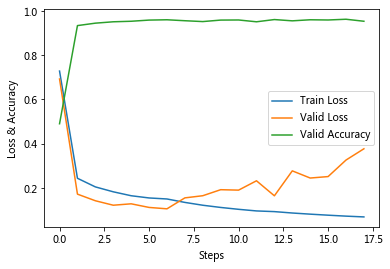

In [28]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()
plt.show()

In [41]:
# 对测试集数据test_data进行预测
test_pred = 

In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score,  roc_curve, auc
# 使用测试集数据衡量模型准确度
accuracy_score( )

0.958173076923077

In [44]:
# 使用测试集数据衡量模型AUC Score
roc_auc_score(  )

0.9582704597905201

In [45]:
fpr, tpr, thresholds = roc_curve(  )
auc(fpr, tpr) 

0.9582704597905201